In [0]:
from jax import jit, grad, vmap, random
from functools import partial
import jax
import jax.numpy as np
from jax.experimental import stax # neural network library
from jax.experimental.stax import GeneralConv, Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax, LeakyRelu, Dropout, Tanh, Sigmoid # neural network layers
from jax.nn import softmax, sigmoid
from jax.nn.initializers import zeros
import matplotlib.pyplot as plt # visualization
import numpy as onp
from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays

In [0]:
#Setup environment and hyperparameters
rng = random.PRNGKey(1)
g_hidden_size = 128
d_hidden_size = 128
g_out_dim = 784
d_out_dim = 1
z_size = 100
smooth = 0.1
learning_rate = 0.002
batch_size = 100
epochs = 100

In [0]:
#Define Generator
gen_init, gen_apply = stax.serial(
    Dense(g_hidden_size), LeakyRelu,
    Dense(g_out_dim), Tanh    
)
g_in_shape = (-1, z_size)
_, gen_params = gen_init(rng, g_in_shape)

In [0]:
#Define Discriminator
disc_init, disc_apply = stax.serial(
    Dense(d_hidden_size), LeakyRelu,
    Dense(d_out_dim)    
)
d_in_shape = (-1, g_out_dim)
_, disc_params = disc_init(rng, d_in_shape)

In [0]:
#Define Losses and Optimizers
def cross_entropy_with_logits(targets, logits):
    predictions = sigmoid(logits)
    return -(targets*np.log(predictions+1e-9)+(1-targets)*np.log(1-predictions+1e-9))

def loss(gen_params, disc_params, input_z, input_real):
    g_out = gen_apply(gen_params, input_z)
    d_logits_real = disc_apply(disc_params, input_real)
    d_logits_fake = disc_apply(disc_params, g_out)
    d_loss_real = np.mean(cross_entropy_with_logits(targets=np.ones_like(d_logits_real)*(1-smooth), logits=d_logits_real))
    d_loss_fake = np.mean(cross_entropy_with_logits(targets=np.zeros_like(d_logits_fake), logits=d_logits_fake))
    d_loss = d_loss_real + d_loss_fake
    g_loss = np.mean(cross_entropy_with_logits(targets=np.ones_like(d_logits_fake), logits=d_logits_fake))
    return g_loss, d_loss

g_opt_init, g_opt_update, g_get_params = optimizers.adam(step_size=learning_rate)
d_opt_init, d_opt_update, d_get_params = optimizers.adam(step_size=learning_rate)
g_opt_state = g_opt_init(gen_params)
d_opt_state = d_opt_init(disc_params)

@jit
def step(i, g_opt_state, d_opt_state, input_z, input_real):
    g_params = g_get_params(g_opt_state)
    d_params = d_get_params(d_opt_state)
    g_loss = lambda x: loss(x, d_params, input_z, input_real)[0]
    d_loss = lambda y: loss(g_params, y, input_z, input_real)[1]
    gen_grad = grad(g_loss)(g_params)
    disc_grad = grad(d_loss)(d_params)
    gl, dl = loss(g_params, d_params, input_z, input_real)
    return g_opt_update(i, gen_grad, g_opt_state), d_opt_update(i, disc_grad, d_opt_state), gl, dl

In [6]:
# Load data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting MNIST_data/train-images-idx3-ubyte.gz


Instructions for updating:
Please use tf.data to implement this functionality.
Instructions for updating:
Please use tf.one_hot on tensors.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
input_z = random.uniform(rng, shape=(batch_size, z_size), minval=-1., maxval=1.)
input_real = mnist.train.next_batch(batch_size)[0]
print(input_z.shape, input_real.shape, loss(gen_params, disc_params, input_z, input_real))

(100, 100) (100, 784) (DeviceArray(0.6549141, dtype=float32), DeviceArray(1.3782516, dtype=float32))


In [8]:
#Training
samples = []
losses = []

for e in range(epochs):
    for ii in range(mnist.train.num_examples // batch_size):
        batch = mnist.train.next_batch(batch_size)

        # Get images, reshape and rescale to pass to D
        batch_images = batch[0].reshape((batch_size, 784))
        batch_images = batch_images * 2 - 1

        # Sample random noise for G
        batch_z = random.uniform(rng, shape=(batch_size, z_size), minval=-1., maxval=1.)

        #Take steps
        g_opt_state, d_opt_state, gl, dl = step(e*mnist.train.num_examples+ii, g_opt_state, d_opt_state, batch_z, batch_images)
        #print(dl,gl)

    # At the end of each epoch, get the losses and print them out
    print("Epoch {}/{}...".format(e + 1, epochs),
        "Discriminator Loss: {:.4f}...".format(dl),
        "Generator Loss: {:.4f}".format(gl))

    # Save losses to view after training
    losses.append((dl, gl))

    # Sample from generator as we're training for viewing afterwards
    sample_z = random.uniform(rng, shape=(16, z_size), minval=-1., maxval=1.)
    gen_params = g_get_params(g_opt_state)
    gen_samples = gen_apply(gen_params, sample_z)
    samples.append(gen_samples)


Epoch 1/100... Discriminator Loss: 0.4087... Generator Loss: 6.7204
Epoch 2/100... Discriminator Loss: 0.5685... Generator Loss: 3.0284
Epoch 3/100... Discriminator Loss: 0.6057... Generator Loss: 5.4414
Epoch 4/100... Discriminator Loss: 1.0570... Generator Loss: 3.3219
Epoch 5/100... Discriminator Loss: 1.0712... Generator Loss: 2.0386
Epoch 6/100... Discriminator Loss: 1.0596... Generator Loss: 2.4803
Epoch 7/100... Discriminator Loss: 1.2293... Generator Loss: 2.6791
Epoch 8/100... Discriminator Loss: 1.1474... Generator Loss: 1.8729
Epoch 9/100... Discriminator Loss: 1.6859... Generator Loss: 3.4461
Epoch 10/100... Discriminator Loss: 0.9622... Generator Loss: 4.9943
Epoch 11/100... Discriminator Loss: 0.9199... Generator Loss: 2.9015
Epoch 12/100... Discriminator Loss: 0.8347... Generator Loss: 2.9110
Epoch 13/100... Discriminator Loss: 0.9569... Generator Loss: 2.2944
Epoch 14/100... Discriminator Loss: 0.8588... Generator Loss: 3.3320
Epoch 15/100... Discriminator Loss: 0.7552.

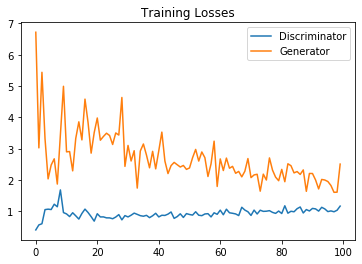

In [9]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

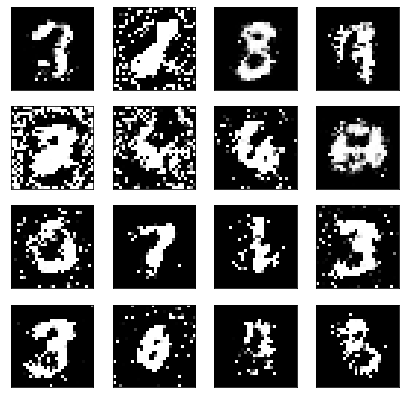

In [10]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes
# Load samples from generator taken while training
_ = view_samples(-1, samples)

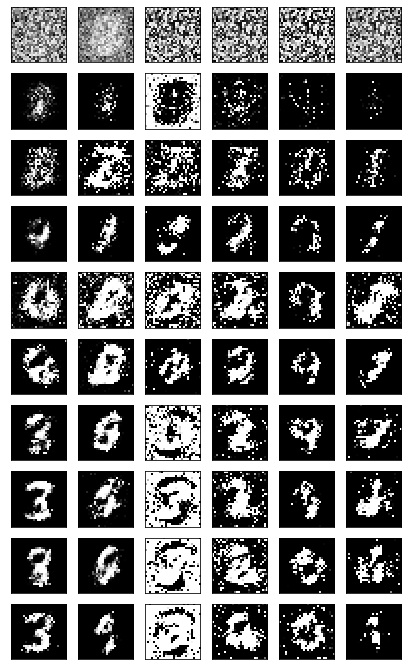

In [11]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

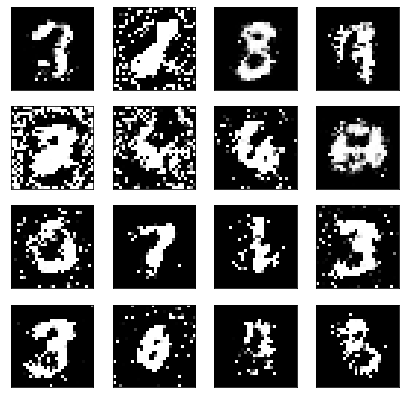

In [12]:
# Sample from generator as we're training for viewing afterwards
sample_z = random.uniform(rng, shape=(16, z_size), minval=-1., maxval=1.)
gen_params = g_get_params(g_opt_state)
gen_samples = gen_apply(gen_params, sample_z)
_ = view_samples(0, [gen_samples])